## Imports and functions

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import itertools
import ot
import glob
import os
import sys
sys.path.append('C:/Users/eriki/OneDrive/Documents/all_folder/Thesis/Thesis/utils')
from utils import calculate_costs, Fourier2, Fourier1

In [11]:
dotmark_pictures_path = "..\\..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
pairs = list(itertools.combinations(image_numbers, 2))

categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = glob.glob(categories_pattern)
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

## Looking into the Cost matrices

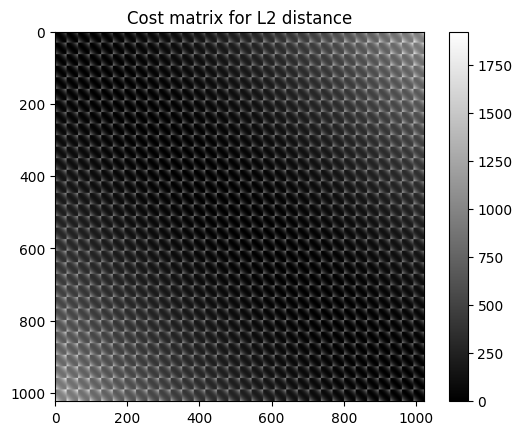

In [12]:
cost_matrix_l2 = calculate_costs((32,32), distance_metric = 'L2')
plt.imshow(cost_matrix_l2, cmap='gray')
plt.colorbar()
plt.title('Cost matrix for L2 distance')
plt.show()

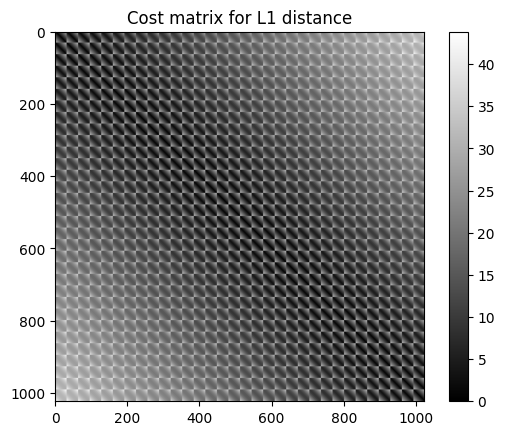

In [13]:
cost_matrix_l1 = calculate_costs((32,32), distance_metric = 'L1')
plt.imshow(cost_matrix_l1, cmap='gray')
plt.colorbar()
plt.title('Cost matrix for L1 distance')
plt.show()

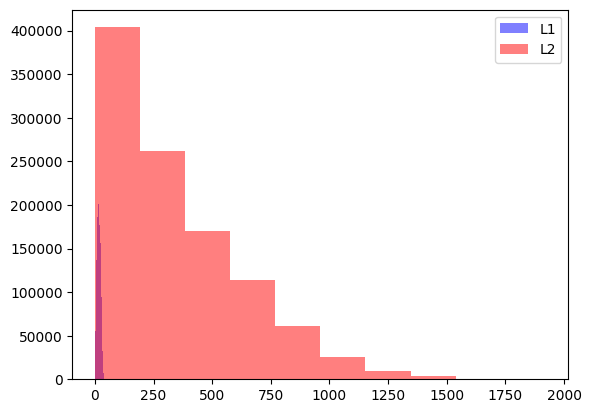

In [14]:
plt.hist(cost_matrix_l1.flatten(), alpha=0.5, label='L1', color='blue')
plt.hist(cost_matrix_l2.flatten(), alpha=0.5, label='L2', color='red')
plt.legend()
plt.show()

## Images, $W_2$ vs $f_{2,2}$

In [15]:
pfm_values_normal = []
pfm_values_shifted = []
w_values = []
T = 2 * np.pi

for category in category_names:
    category_dir = os.path.join(full_path, category)
    start = time.time()
    for image_pair in pairs:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[0]}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        path_im2 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[1]}.png")
        im2 = cv2.imread(path_im2, cv2.IMREAD_GRAYSCALE)
        im2 = cv2.resize(im2, (resolution, resolution))
        im2 = im2 / im2.sum()  # Normalize
        
        pfm = Fourier2(im1, im2)
        pfm_values_normal.append(pfm)

        #Calculate the EMD
        # cost_matrix = calculate_costs(im1.shape, distance_metric = 'L2')
        w_dist = np.sqrt(ot.emd2(im1.flatten(), im2.flatten(), cost_matrix_l2))
        w_values.append(w_dist)
    
    end = time.time()
    print(f'{end - start} Time elapsed for Category {category}')

6.528806686401367 Time elapsed for Category CauchyDensity
9.291707277297974 Time elapsed for Category ClassicImages
11.04464316368103 Time elapsed for Category GRFmoderate
9.953443050384521 Time elapsed for Category GRFrough
12.475314140319824 Time elapsed for Category GRFsmooth
6.378900051116943 Time elapsed for Category LogGRF
7.642193555831909 Time elapsed for Category LogitGRF
3.584918737411499 Time elapsed for Category MicroscopyImages
1.884615421295166 Time elapsed for Category Shapes
10.71465015411377 Time elapsed for Category WhiteNoise


The lower bound, 
$$
2\sqrt2 \cdot W_2 \ge f_{2,2} \rightarrow W_2 \ge \frac{1}{2\sqrt2} f_{2,2}
$$

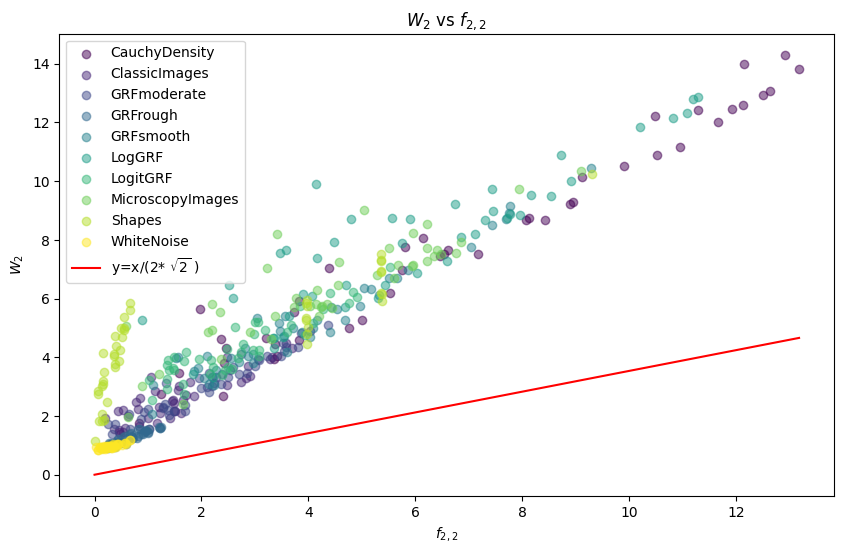

In [566]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
for i in range(10):  # 10 groups of 45 samples each
    start = i * 45
    end = (i + 1) * 45
    plt.scatter(pfm_values_normal[start:end], w_values[start:end], color=colors[i], alpha=0.5, label=f'{category_names[i]}')
x = np.linspace(0, np.max(pfm_values_normal), 100)
plt.plot(x, x / (2 * np.sqrt(2)), color='red', label='y=x/(2* $\sqrt{2}$ )')
plt.title('$W_2$ vs $f_{2,2}$')
plt.xlabel('$f_{2,2}$')
plt.ylabel('$W_2$')
plt.legend()
plt.show()

The upper bound, 
$$
W_2^2 \le \frac{T^3}{\pi} \cdot f_{2,2} \rightarrow W_2 \le \sqrt{\frac{T^3}{\pi} \cdot f_{2,2}}
$$

In [567]:
pfm_sqrt = np.sqrt(np.array(pfm_values_normal))
w_sqrt = np.sqrt(np.array(w_values))
pfm_sqrt_multipilied = pfm_sqrt * np.sqrt(T ** 3 / np.pi)

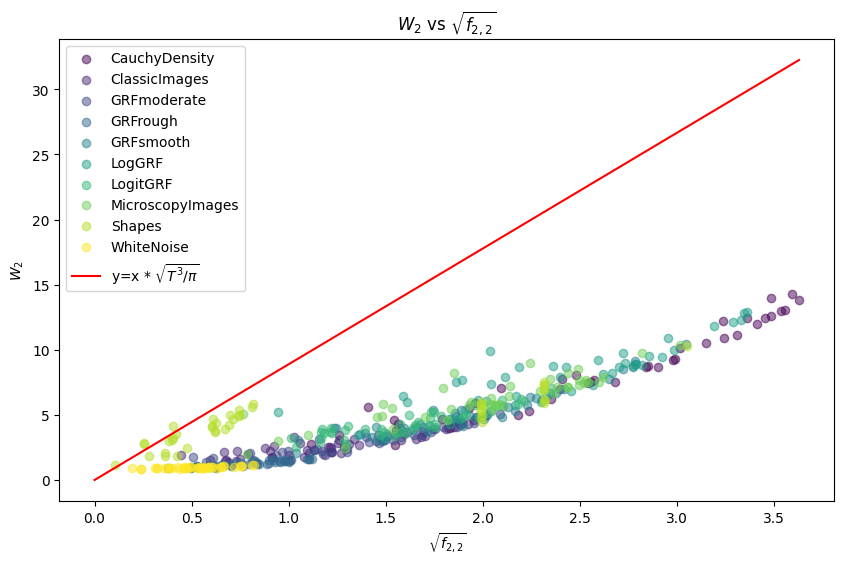

In [568]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
for i in range(10):  # 10 groups of 45 samples each
    start = i * 45
    end = (i + 1) * 45
    plt.scatter(pfm_sqrt[start:end], w_values[start:end], color=colors[i], alpha=0.5, label=f'{category_names[i]}')
x = np.linspace(0, np.max(pfm_sqrt), 100)
plt.plot(x, x * np.sqrt(T ** 3 / np.pi), color='red', label='y=x * $\sqrt{T^3 / \pi}$')
plt.title('$W_2$ vs $\sqrt{f_{2,2}}$')
plt.xlabel('$\sqrt{f_{2,2}}$')
plt.ylabel('$W_2$')
plt.legend()
plt.show()

In [569]:
ratios = np.array(w_values) / np.array(pfm_sqrt)

In [570]:
print(max(ratios))
print(np.sqrt(T ** 3 / np.pi))

11.197378947089426
8.885765876316732


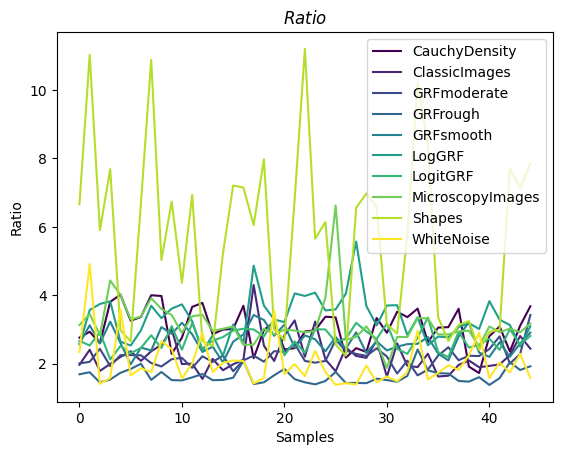

In [571]:
for i in range(10):
    start = i * 45
    end = (i + 1) * 45
    plt.plot(ratios[start:end], color=colors[i], label=f'{category_names[i]}')

plt.xlabel('Samples')
plt.ylabel('Ratio')
plt.legend()
plt.title('$Ratio$')
plt.show()

## Images, $W_1$ vs $f_{1,2}$

In [536]:
pfm_values_normal = []
pfm_values_simplified = []
w_values = []

for category in category_names:
    category_dir = os.path.join(full_path, category)
    start = time.time()
    for image_pair in pairs:
        # Loading and normalizing images
        path_im1 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[0]}.png")
        im1 = cv2.imread(path_im1, cv2.IMREAD_GRAYSCALE)
        im1 = cv2.resize(im1, (resolution, resolution))
        im1 = im1 / im1.sum()  # Normalize
        path_im2 = os.path.join(category_dir, f"picture{resolution}_10{image_pair[1]}.png")
        im2 = cv2.imread(path_im2, cv2.IMREAD_GRAYSCALE)
        im2 = cv2.resize(im2, (resolution, resolution))
        im2 = im2 / im2.sum()  # Normalize
        
        pfm = Fourier1(im1, im2)
        pfm_values_normal.append(pfm)

        #Calculate the EMD
        # cost_matrix = calculate_costs(im1.shape, distance_metric = 'L1')
        w_dist = ot.emd2(im1.flatten(), im2.flatten(), cost_matrix_l1)
        w_values.append(w_dist)
    
    end = time.time()
    print(f'{end - start} Time elapsed for Category {category}')

4.1781721115112305 Time elapsed for Category CauchyDensity
6.633758544921875 Time elapsed for Category ClassicImages
5.55159068107605 Time elapsed for Category GRFmoderate
6.188610315322876 Time elapsed for Category GRFrough
6.128077507019043 Time elapsed for Category GRFsmooth
4.121703863143921 Time elapsed for Category LogGRF
5.020105838775635 Time elapsed for Category LogitGRF
2.7068846225738525 Time elapsed for Category MicroscopyImages
1.492030382156372 Time elapsed for Category Shapes
6.378925800323486 Time elapsed for Category WhiteNoise


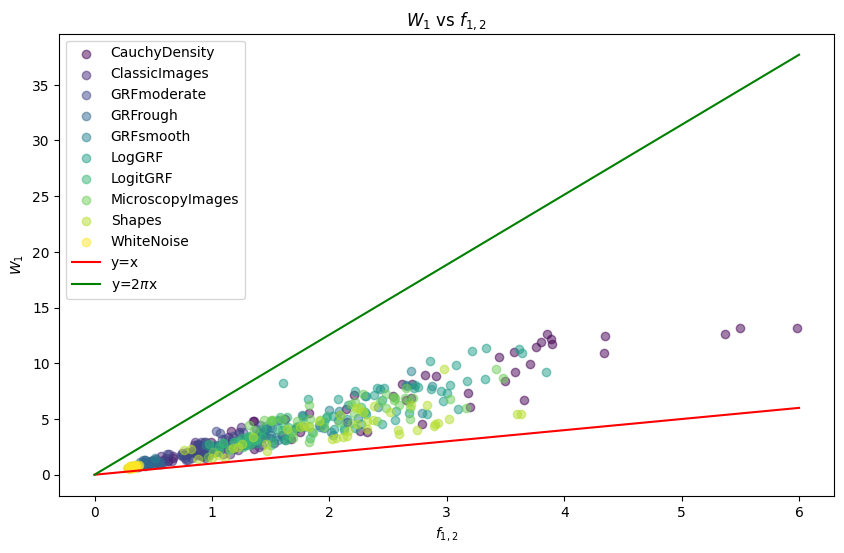

In [541]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # 10 distinct colors
for i in range(10):  # 10 groups of 45 samples each
    start = i * 45
    end = (i + 1) * 45
    plt.scatter(pfm_values_normal[start:end], w_values[start:end], color=colors[i], alpha=0.5, label=f'{category_names[i]}')

# draw a line of y=x
x = np.linspace(0, 6, 100)
plt.plot(x, x, color='red', label='y=x')
plt.plot(x, x * (2 * np.pi), color='green', label='y=2$\pi$x')
plt.title('$W_1$ vs $f_{1,2}$')
plt.ylabel('$W_1$')
plt.xlabel('$f_{1,2}$')
plt.legend()
plt.show()

In [538]:
ratios = np.array(w_values) / (np.array(pfm_values_normal) )

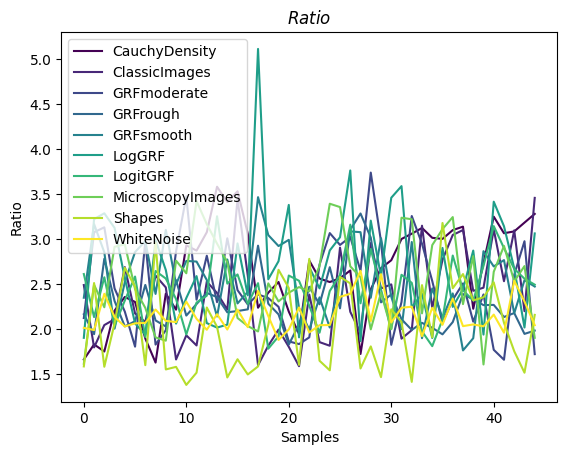

In [539]:
for i in range(10):
    start = i * 45
    end = (i + 1) * 45
    plt.plot(ratios[start:end], color=colors[i], label=f'{category_names[i]}')

plt.xlabel('Samples')
plt.ylabel('Ratio')
plt.legend()
plt.title('$Ratio$')
plt.show()